# Build an AI Chatbot to Run Code and Tweak plots

[Build an AI Chatbot to Run Code and Tweak plots](https://blog.holoviz.org/posts/tweak-mpl-chat/) by Andrew Huang and Sophia Yang (December 22, 2023)

## Import packages

In [1]:
# Install required packages
# !pip3 install mistralai panel

In [2]:
# Import packages
import re
import os
import panel as pn
from mistralai.async_client import MistralAsyncClient
from mistralai.models.chat_completion import ChatMessage
from panel.io.mime_render import exec_with_return

In [3]:
# Initialize Panel extension
pn.extension("codeeditor", sizing_mode="stretch_width")

## Define default behaviors

In [4]:
# Set LLM to 'mistral-small'
LL_MODEL = 'mistral-small'

In [5]:
# Define system message
SYSTEM_MESSAGE = ChatMessage(
    role='system',
    content=(
        'You are a renowned data visualization expert '
        'with a strong background in matplotlib. '
        'Your primary goal is to assist the user '
        'in edit the code based on user request '
        'using best practices. Simply provide code '
        'in code fences (```python). You must have `fig` '
        'as the last line of code'
    ),
)

In [6]:
# Default format of user content
# Combine user message then current Python code
USER_CONTENT_FORMAT = """
Request:
{content}
Code:
```python
{code}
```
""".strip()

In [7]:
DEFAULT_MATPLOTLIB = """
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(title='Plot Title', xlabel='X Label', ylabel='Y Label')
x = np.linspace(1, 10)
y = np.sin(x)
z = np.cos(x)
c = np.log(x)
ax.plot(x, y, c='blue', label='sin')
ax.plot(x, z, c='orange', label='cos')
img = ax.scatter(x, c, c=c, label='log')
plt.colorbar(img, label='Colorbar')
plt.legend()
# must have fig at the end!
fig
""".strip()

## Define the `callback` function

In [8]:
# Set client to Mistral API
client = MistralAsyncClient(api_key=os.environ['MISTRAL_API_KEY'])

In [9]:
# Define asynchronous callback function
async def callback(content: str, user: str, instance: pn.chat.ChatInterface):
    # system
    messages = [SYSTEM_MESSAGE]

    # history
    messages.extend([ChatMessage(**message) for message in instance.serialize()[1:-1]])

    # new user contents
    user_content = USER_CONTENT_FORMAT.format(
        content=content, code=code_editor.value
    )
    messages.append(ChatMessage(role='user', content=user_content))

    # stream LLM tokens
    message = ""
    async for chunk in client.chat_stream(model=LL_MODEL, messages=messages):
        if chunk.choices[0].delta.content is not None:
            message += chunk.choices[0].delta.content
            yield message

    # extract code
    llm_code = re.findall(r"```python\n(.*)\n```", message, re.DOTALL)[0]
    if llm_code.splitlines()[-1].strip() != 'fig':
        llm_code += '\nfig'
    code_editor.value = llm_code

## Define widgets

In [10]:
# ChatInterface widget
chat_interface = pn.chat.ChatInterface(
    callback=callback,
    show_clear=False,
    show_undo=False,
    show_button_name=False,
    message_params=dict(
        show_reaction_icons=False,
        show_copy_icon=False,
    ),
    height=700,
    callback_exception='verbose',
)

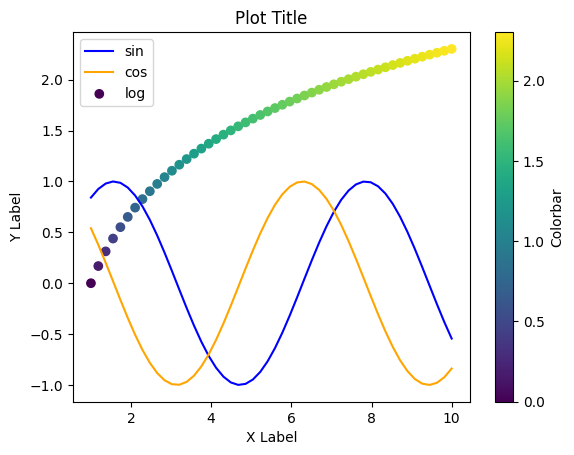

In [11]:
# Panel object to show the Matplotlib plot from the Python code
matplotlib_pane = pn.pane.Matplotlib(
    exec_with_return(DEFAULT_MATPLOTLIB),
    sizing_mode='stretch_both',
    tight=True,
)

In [12]:
# Panel object that allows embedding a code editor
code_editor = pn.widgets.CodeEditor(
    value=DEFAULT_MATPLOTLIB,
    sizing_mode='stretch_both',
)

In [13]:
# Define function to update plot
def update_plot(event):
    matplotlib_pane.object = exec_with_return(event.new)

In [14]:
# watch for code changes
code_editor.param.watch(update_plot, 'value')

Watcher(inst=CodeEditor(sizing_mode='stretch_both', value="import numpy as np\nimpor...), cls=<class 'panel.widgets.codeeditor.CodeEditor'>, fn=<function update_plot at 0x128900a40>, mode='args', onlychanged=True, parameter_names=('value',), what='value', queued=False, precedence=0)

## Define layout

FastListTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo(dark_mode=True, device_pixel_ratio=1, language='en-GB', timezone='Pacific/Honolulu', timezone_offset=600, webdriver=False)
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [main-4975459792] Tabs(sizing_mode='stretch_width')
        [0] Matplotlib(Figure, sizing_mode='stretch_both', tight=True)
        [1] CodeEditor(sizing_mode='stretch_both', value="import numpy as np\nimpor...)
    [nav-4723871952] ChatInterface(_button_data={'send': _ChatButtonData(i...}, _buttons={'send': Button(icon='send...}, _input_container=Row, _input_layout=Row, _placeholder=ChatMessage, _widgets={'TextInput': TextInput(cs...}, callback=<function callback a..., callback_exception='verbose', height=700, message_params={'show_reaction_icons': Fa...}, show_button_name=False, show_clear=False, show_undo=False, sizing_mode='stretch_width', widgets=[TextInput(css_classes=['c...])
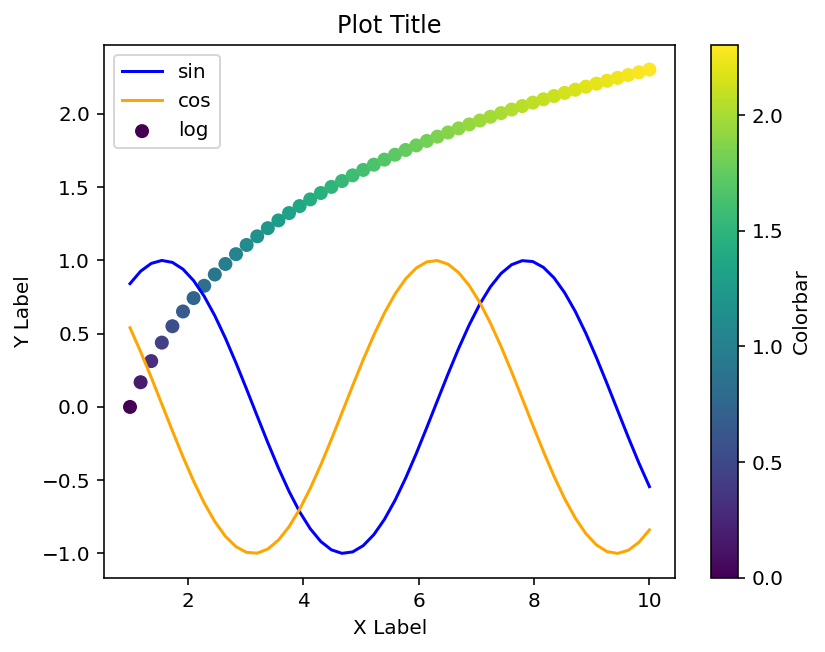

In [15]:
# Layout
tabs = pn.Tabs(
    ('Plot', matplotlib_pane),
    ('Code', code_editor),
)

sidebar = [chat_interface]

main = [tabs]

template = pn.template.FastListTemplate(
    sidebar=sidebar,
    main=main,
    sidebar_width=600,
    main_layout=None,
    accent_base_color='#fd7000',
    header_background='#fd7000',
)

template.servable()

To interact with this app:

1. In CLI, change directory to folder containing this notebook
2. Run panel serve mixtral-mpl-chatbot.ipynb
3. Open a new browser tab and type in http://localhost:5006/mixtral-chatbot (where Bokeh app is running at)